In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

import seaborn as sns
from scipy import stats
!pip install statsmodels
import statsmodels.api as sm
import time

In [2]:
app_train_red = pd.read_csv("app_train_red.csv")
# app_test_red = pd.read_csv("app_test_red.csv")

In [3]:
# app_train_red.drop("0")
app_train_red.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


## Current Applications EDA

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='DAYS_EMPLOYED'>

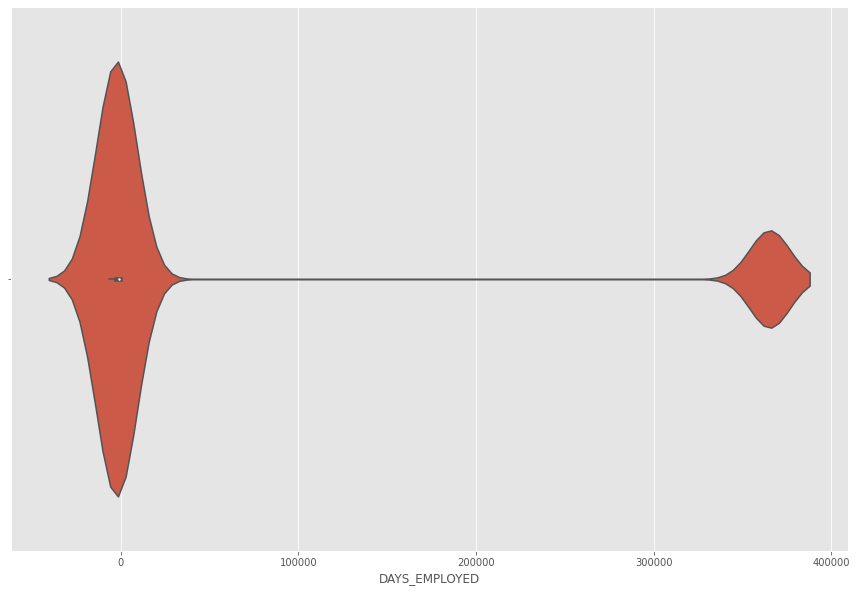

In [ ]:
sns.violinplot(app_train_red.DAYS_EMPLOYED)

A violin plot of the number of days the borrower has been employed brings up something highly suspicious. The days employed are counted with respect to the current application, so the majority of them are "negative", as is expected. Oddly, there is a giant spike at about 350000 days positive. Since days are counted as days before submition of the application, this makes the positve 350000 spike highly suspect, not to mention it eqauted to  about 800+ years. 

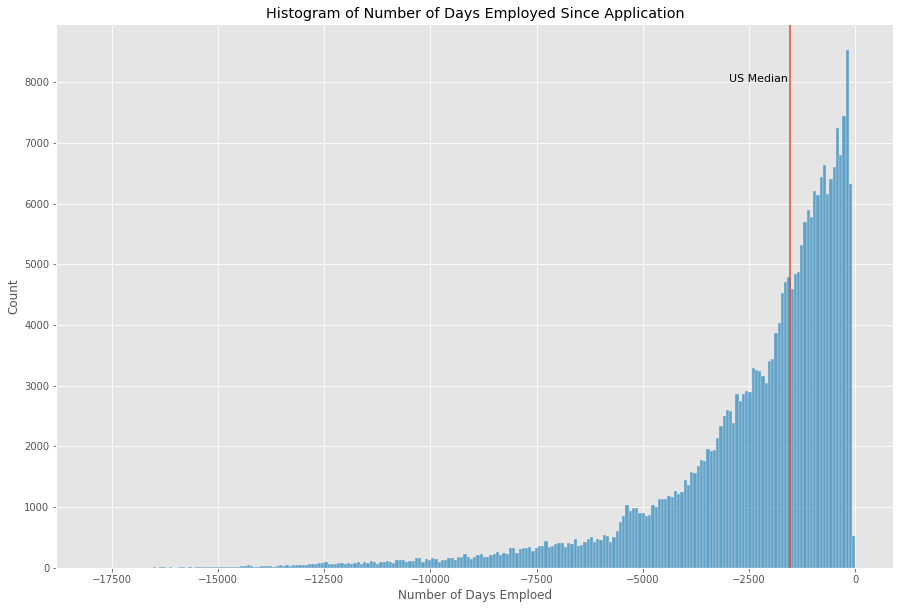

In [ ]:
fig, ax1 = plt.subplots()
sns.histplot(app_train_red.DAYS_EMPLOYED[app_train_red.DAYS_EMPLOYED < 10], ax = ax1)
plt.axvline(- 4.2 * 365, 0, 8200)
ax1.set_title("Histogram of Number of Days Employed Since Application")
ax1.set_xlabel("Number of Days Emploed")
ax1.set_ylabel("Count")
ax1.text(- 4.2 * 365 - 1450, 8000, "US Median", fontsize = 11)
plt.show()

Excluding the outliers, the rest of the data exhibits normal behavior and appears to be lognormally distributed. This seems reasonable since according to the Bereau of Labor and Statistics, the median number of years workers tend to stay with the same employer is about 4.2 years in 2020 (assuming this is excluding the rise of unemployment and job losses due to the pandemic). Since Home Credit is primarily based in Asia, I expect the distribution to be similar to the US's but skewed to the lower end, meaning less people being tenured longer with the same employer. Comparing the US median to the dataset shows this to be true. The 4.2 year mark has 56.7% of the applicants being employed less than 4.2 years.

The more interesting question is what is up with the people having a positive employment time, ie the weird ones. 

In [ ]:
len(app_train_red.DAYS_EMPLOYED[app_train_red.DAYS_EMPLOYED < - 4.2 * 365]) / len(app_train_red) * 100

43.30154043269997

#### The Weird Ones

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Probability'>

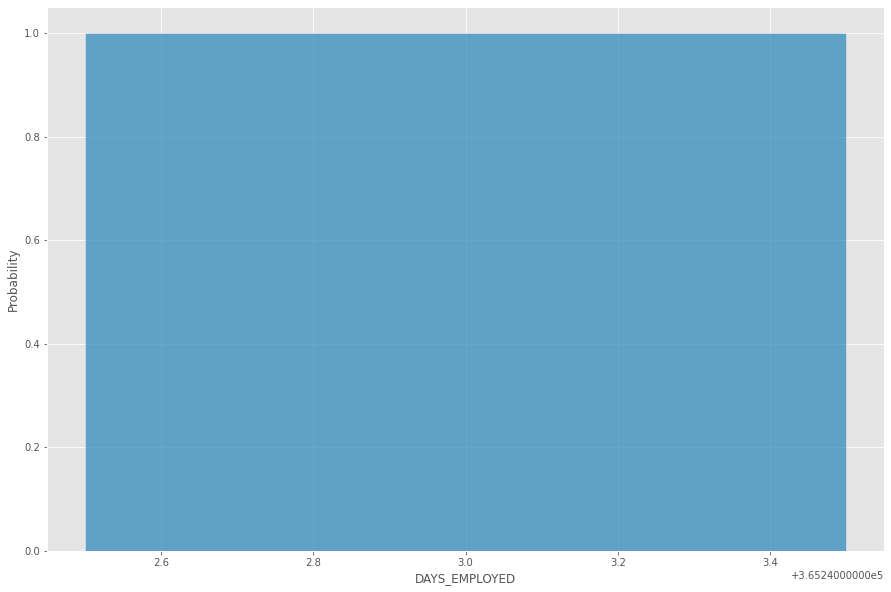

In [ ]:
weird_ones = app_train_red[app_train_red.DAYS_EMPLOYED > 0]
sns.histplot(x = weird_ones.DAYS_EMPLOYED, stat = "probability")

The weird ones all have a specific values assigned to them, as if it was done on purpose. They are all concentrated on the value of 365240 days, which translates to 1000 years, which is a long time to be employed(?). Perhaps this is less weird and more compensating for people who are unemployed or something to that extent which was not included in the dataset description instead of leaving the value as missing. 

<AxesSubplot:xlabel='TARGET', ylabel='count'>

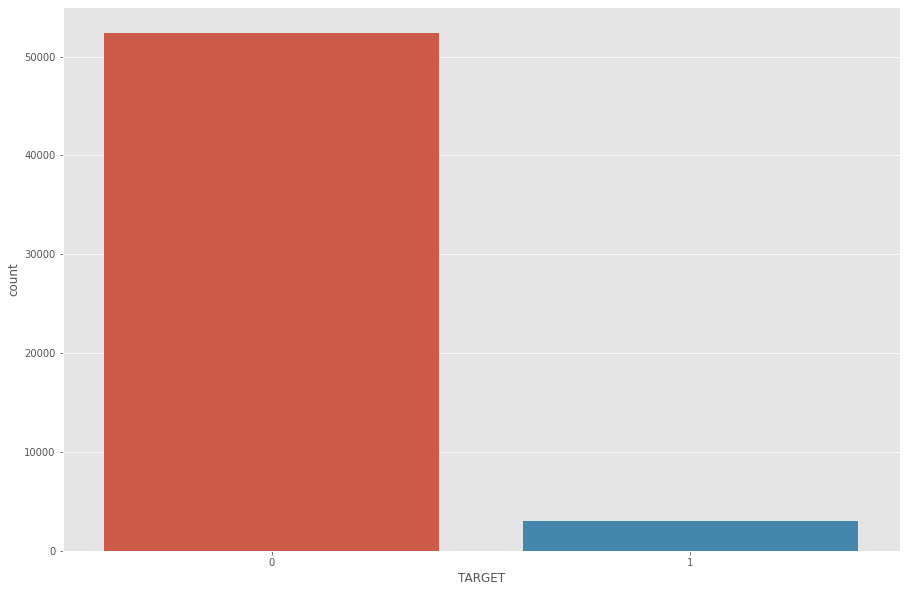

In [ ]:
sns.countplot(x = weird_ones.TARGET)

In [ ]:
df = pd.merge(app_train_red, weird_ones, on = "SK_ID_CURR", how = "left", indicator = "Weird")
df.Weird = df.Weird == "both"

<AxesSubplot:xlabel='Weird', ylabel='count'>

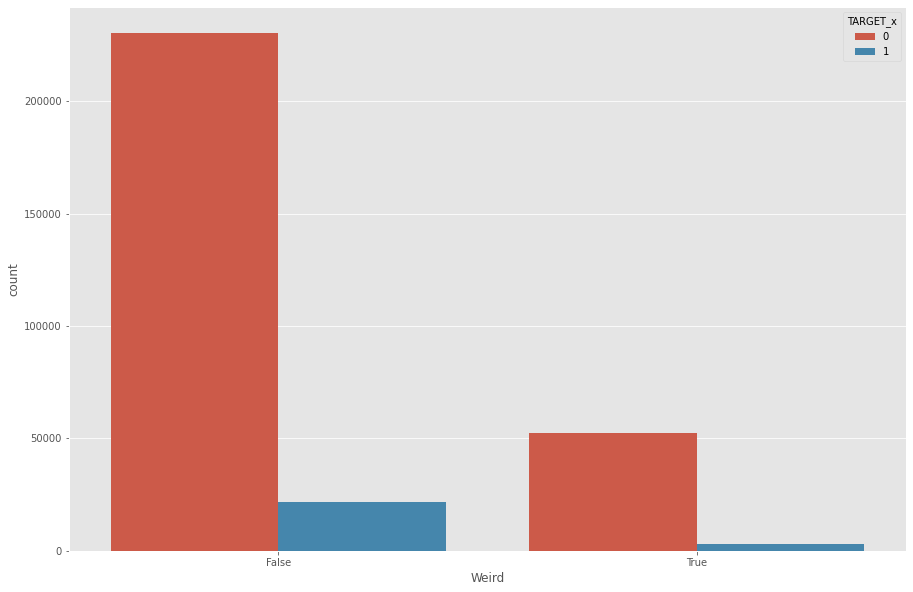

In [ ]:
sns.countplot(x = df.Weird, hue = df.TARGET_x)
# trying to find the percentage of target variable relative to the amount of people in weird group vs non weird

   Weird  TARGET_x   total   percent
0  False         0  230302  0.913400
1  False         1   21835  0.086600
2   True         0   52384  0.946004
3   True         1    2990  0.053996


<AxesSubplot:xlabel='Weird', ylabel='percent'>

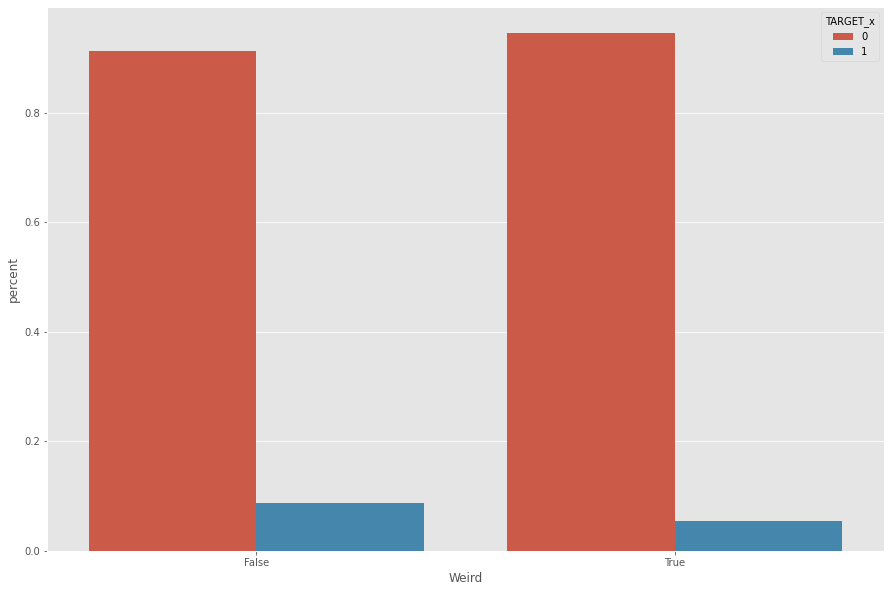

In [ ]:
df1 = df.groupby(["Weird", "TARGET_x"]).TARGET_x.agg(total = "count").reset_index()
df2 = df1.groupby(by = "Weird").apply(lambda x: x / x.sum())
df1["percent"] = df2.total
print(df1)
sns.barplot(x = "Weird", y = "percent", data = df1, hue = "TARGET_x")

In [ ]:
contingency_table = pd.crosstab(df.Weird, df.TARGET_x)
contingency_table

TARGET_x,0,1
Weird,,
False,230302,21835
True,52384,2990


In [ ]:
def cramers_v(cross_table):
    chi, p, dofs, exp_cnts = stats.chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi = chi / n
    k = cross_table.shape[0]
    r = cross_table.shape[1]
    v = np.sqrt((chi / n) / (min(k-1, r-1)))

    phi_bar = max(0, phi - (k - 1)*(r - 1) / (n - 1))
    k_bar = k - (k-1)**2 / (n-1)
    r_bar = r - (r-1)**2 / (n-1)
    v_corrected = np.sqrt(phi_bar / min(k_bar - 1, r_bar - 1))
    return v, v_corrected, p, chi

In [ ]:
cram_v, cram_v_corrected, p, chi = cramers_v(contingency_table)
print("The Chi-Squared statistic is %f and the corresponding p-value is %f. Moreover, the Cramer's V statistic is %f and the bias corrected Cramer's V statistic is %f" %(chi, p, cram_v, cram_v_corrected))

The Chi-Squared statistic is 649.888509 and the corresponding p-value is 0.000000. Moreover, the Cramer's V statistic is 0.045972 and the bias corrected Cramer's V statistic is 0.045936


<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='Weird'>

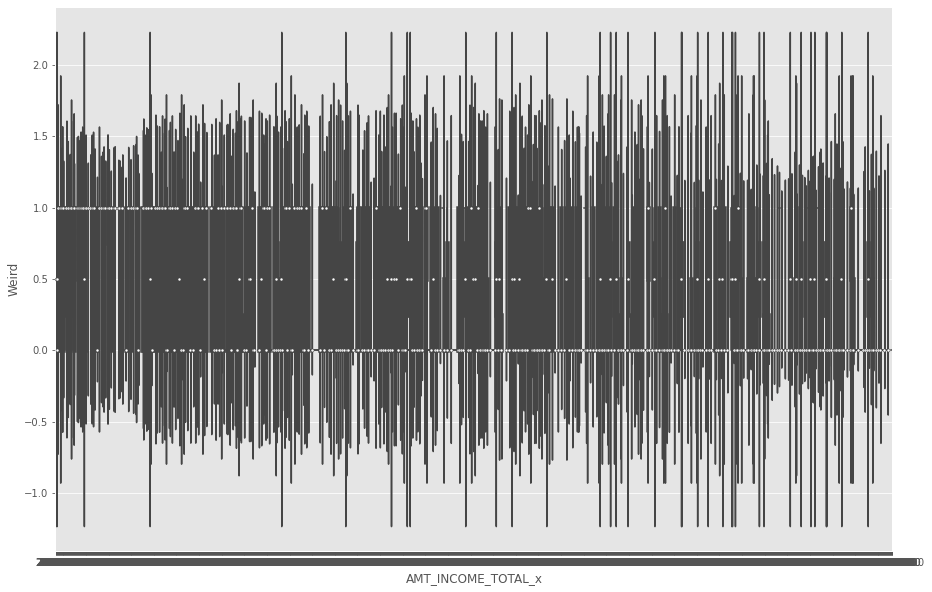

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
sns.kdeplot(x =  df.AMT_INCOME_TOTAL_x, y = df.Weird)

In [ ]:
df.AMT_INCOME_TOTAL_x

0         202500.0
1         270000.0
2          67500.0
3         135000.0
4         121500.0
            ...   
307506    157500.0
307507     72000.0
307508    153000.0
307509    171000.0
307510    157500.0
Name: AMT_INCOME_TOTAL_x, Length: 307511, dtype: float64

In [4]:
app_train_red.value_counts("NAME_FAMILY_STATUS")

NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
dtype: int64

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9263f292-ea73-48e7-8892-f3d3ed1db03c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>